1.1简单层中的乘法层

In [1]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y                
        out = x * y

        return out

    def backward(self, dout):
        dx = dout * self.y # 翻转 x 和 y ；导数（dout）是上游传递来的导数
        dy = dout * self.x

        return dx, dy

In [2]:
apple = 100
apple_num = 2
tax = 1.1
# layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()
# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)
print(price) # 220
# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
print(dapple, dapple_num, dtax) # 2.2 110 200

220.00000000000003
2.2 110.00000000000001 200


1.2简单层中的加法层

In [3]:
class AddLayer:
    def __init__(self):
        pass  # pass表示“什么也不运行”

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy

In [4]:
# coding: utf-8

apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)


price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


2.1激活函数层的ReLU 层
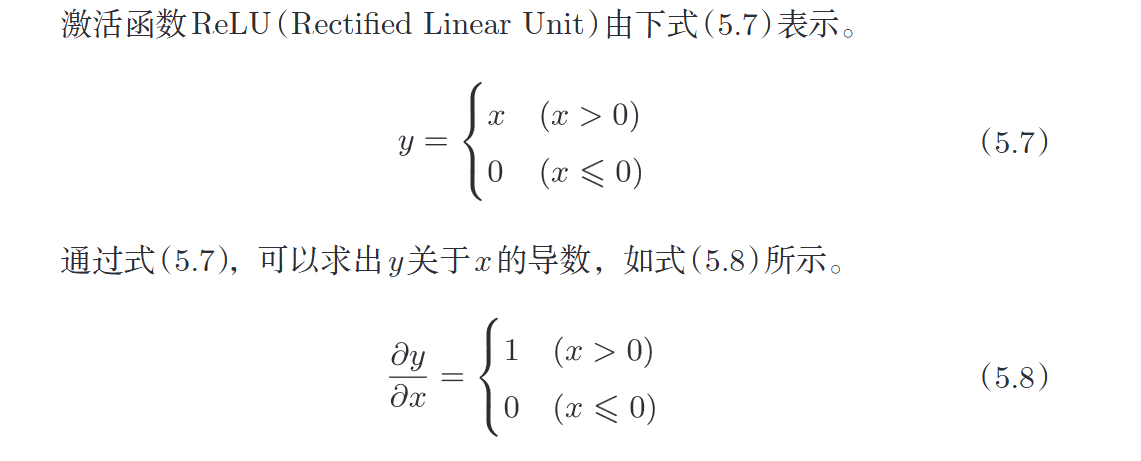

In [5]:
class Relu:
    def __init__(self):
        self.mask = None #表示在前向传播之前，还没有任何数据被处理，等待前向传播时设置
#这个变量 mask 是由 True/False 构成的 NumPy 数组 ，它会把正向传播时的输入 x 的元素中小于等于 0 的地方保存为 True，大于 0 保存为 False
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy() # 重新创建输入数据的副本（避免修改原始数据）
        out[self.mask] = 0 #将out中对应mask为True的位置的值设置为0

        return out
    
    def backward(self, dout):
        dout[self.mask] = 0 #使用保存的 self.mask，将true的值设为0 
        dx = dout
        return dx

In [6]:
import numpy as np
x = np.array( [[1.0, -0.5], [-2.0, 3.0]] )
print(x)
mask = (x <= 0)
print(mask)

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]


In [7]:
relu = Relu()
x = np.array([-1, 0.5, 2, -0.3])
out = relu.forward(x)
print(out)

dout = np.array([0.8, -0.2, 1.5, 0.3]) #来自上一层的梯度反向传播
dx = relu.backward(dout) #将从上游传来的 dout 的mask 中的元素为 True 的地方设为 0
print(dx) #0位和3位依旧是0

[0.  0.5 2.  0. ]
[ 0.  -0.2  1.5  0. ]


2.2 激活函数层的Sigmoid 层
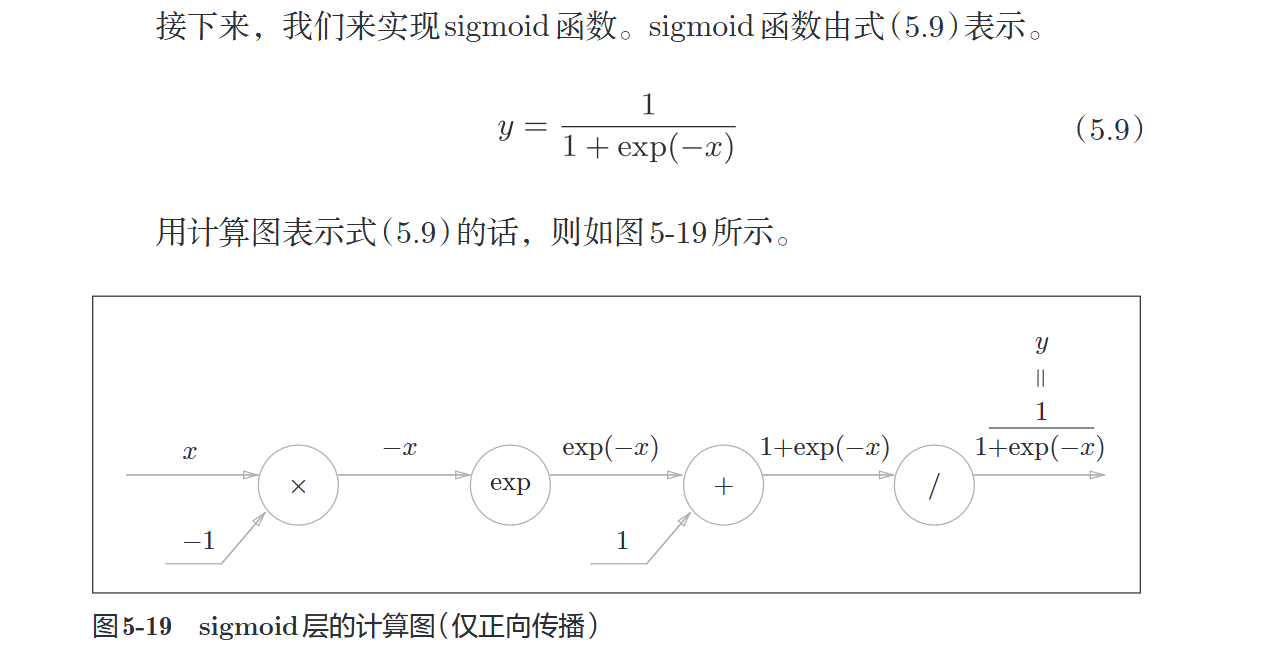

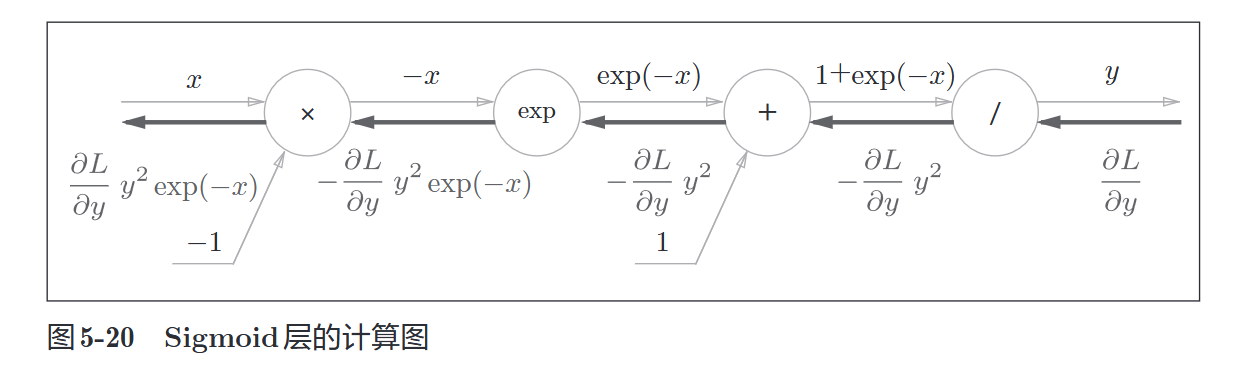

In [8]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out

        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [9]:
sigmoid = Sigmoid()
x = np.array([2.0,1.0,0.0])  # 输入值
y = sigmoid.forward(x)  # 计算 sigmoid 输出
dx = sigmoid.backward(dout = 0.5)
print(y,dx)

[0.88079708 0.73105858 0.5       ] [0.05249679 0.09830597 0.125     ]


3.1 Affine层的实现 :神经网络的正向传播中进行的矩阵的乘积运算在几何学领域被称为“仿射变换”。因此，这里将进行仿射变换的处理实现为Affine 层。
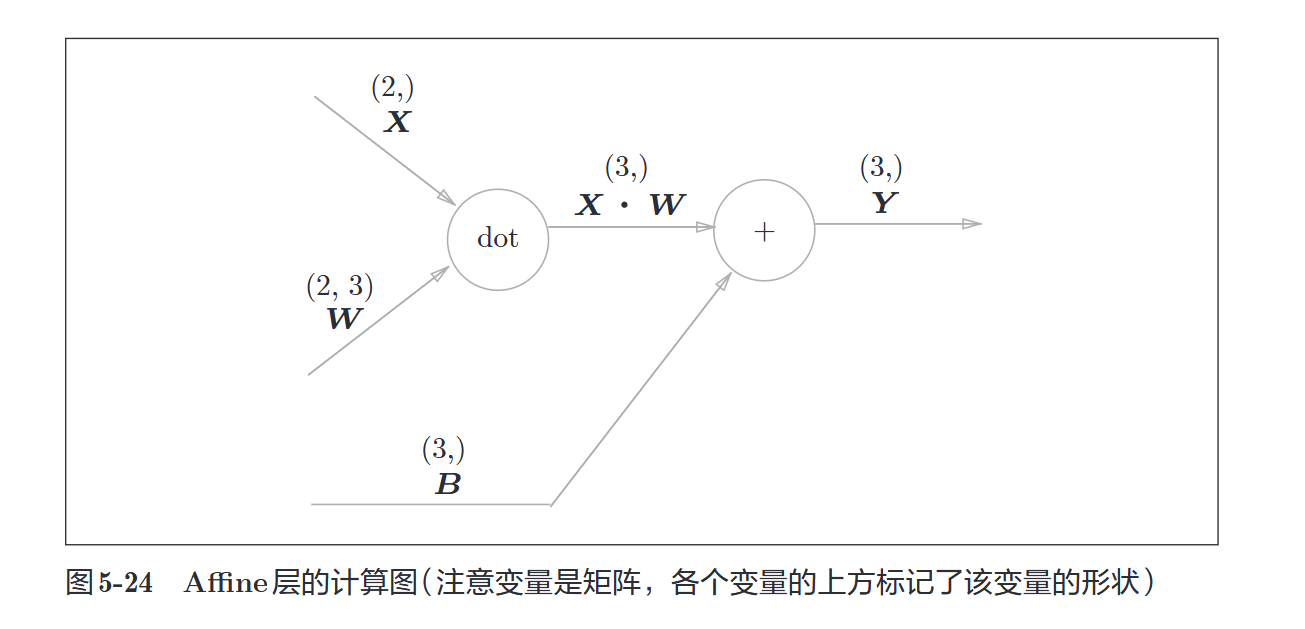

In [10]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

In [11]:
x = np.array([[1.0, 0.5],  # 输入数据 (2个样本，每个样本2个特征)
              [-0.4, 2.1]])
W = np.array([[0.1, 0.3, -0.2],  # 权重矩阵 (2输入特征，3个输出)
              [-0.5, 0.8, 0.7]])
b = np.array([0.1, 0.2, 0.3])    # 偏置向量 (3个输出)
# 创建Affine层
affine = Affine(W, b) #读取了W和B

# 前向传播
out = affine.forward(x)
print("前向传播输出:")
print(out)
print("输出形状:", out.shape)

# 假设从上一层传来的梯度 (形状与输出相同)
dout = np.array([[0.5, -0.3, 1.2],
                 [0.1, -0.8, 0.4]])

# 反向传播
dx = affine.backward(dout)

print("\n反向传播结果:")
print("输入梯度 (dx):")
print(dx) #2x2
print("\n权重梯度 (dW):")
print(affine.dW)
print("\n偏置梯度 (db):")
print(affine.db)

print("\n affine作为self参数传递给了方法") #`affine`是`Affine`类的一个实例（对象），self 参数自动引用当前实例
print(affine.x)

前向传播输出:
[[-0.05  0.9   0.45]
 [-0.99  1.76  1.85]]
输出形状: (2, 3)

反向传播结果:
输入梯度 (dx):
[[-0.28  0.35]
 [-0.31 -0.41]]

权重梯度 (dW):
[[ 0.46  0.02  1.04]
 [ 0.46 -1.83  1.44]]

偏置梯度 (db):
[ 0.6 -1.1  1.6]

 affine作为self参数传递给了方法
[[ 1.   0.5]
 [-0.4  2.1]]


3.2  Softmax-with-Loss 层:softmax 函数会将输入值正规化之后再输出
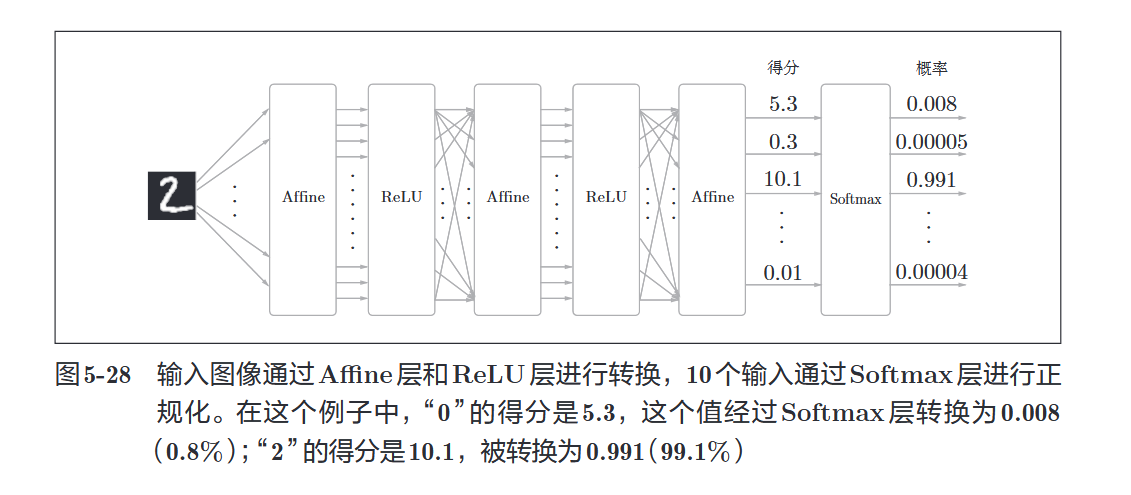

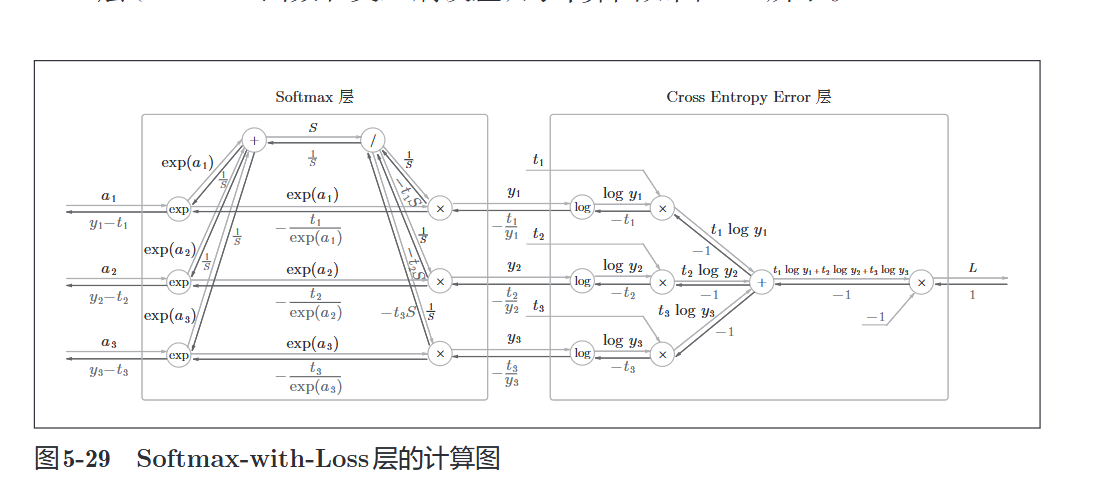

In [12]:
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c) # 溢出对策
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta)) #添加一个微小值可以防止负无限大的发生（np.log0）     
   
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 损失
        self.y = None # softmax 的输出
        self.t = None # 监督数据（one-hot vector）
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size  #传递给前一层的梯度 dx 是每个样本的平均梯度
        #因为这一层是损失层的反向传播，所以需要在损失函数计算后进行梯度平均化，否则计算结果是样本数的总梯度，学习率根据批次大小调整
        return dx

In [13]:
# 示例数据
x = np.array([[1.0, 2.0, 3.0],   # 样本1的logits
              [0.5, 1.5, 2.5]])  # 样本2的logits

t = np.array([[0, 0, 1],          # 样本1的真实标签（类别2）
              [0, 1, 0]])         # 样本2的真实标签（类别1）

# 创建SoftmaxWithLoss实例
layer = SoftmaxWithLoss()

# 前向传播
loss = layer.forward(x, t)
print("前向传播结果:")
print(f"Softmax输出: \n{np.around(layer.y, 4)}")
print(f"交叉熵损失: {loss:.4f}\n")

# 反向传播
dx = layer.backward()
print("反向传播结果:")
print(f"输入梯度: \n{np.around(dx, 4)}")  #np.around()函数用于返回五舍六入后的值，可指定精度。 4位小数

前向传播结果:
Softmax输出: 
[[0.056  0.1523 0.4141]
 [0.034  0.0924 0.2512]]
交叉熵损失: 3.2634

反向传播结果:
输入梯度: 
[[ 0.028   0.0762 -0.293 ]
 [ 0.017  -0.4538  0.1256]]


4.误差反向传播法的实现 神经网络搭建总结

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

     # 1、初始化权重，参数从头开始依次表示输入层的神经元数、隐藏层的神经元数、输出层的神经元数
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}#在params中创建字典储存键值对，params 变量中保存了该神经网络所需的全部参数
        #生成一个形状为 (input_size, hidden_size) 的矩阵，元素服从标准正态分布（均值=0，标准差=1）
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size) #隐藏层偏置（零初始化）
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size) #输出层偏置（零初始化）

        # 2、生成层——————有序字典可以通过调用即可实现前向传播/反向传播
        self.layers = OrderedDict() #OrderedDict是有序字典，可以记住元素添加的顺序：保存神经网络的层的有序字典型变量
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1']) # 对应第一个隐藏层
        self.layers['Relu1'] = Relu() #激活函数层
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2']) # 对应输出层

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):  #参数 x 是图像数据
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # 3.损失计算 loss()    x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    #4. 准确率计算 accuracy() 
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    #5.数值梯度计算/正向传播  x:输入数据, t:监督数据
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads
    
    #6.反向传播：反向传播必须在前向传播之后执行
    def gradient(self, x, t):
        # forward
        self.loss(x, t)  #调用loss方法进行前向传播

        # backward
        dout = 1 #初始化梯度为1，因为损失函数对自身的导数为1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse() # 反转层顺序：从后往前——原顺序：Affine1→Relu1→Affine2 → 反转为：Affine2→Relu1→Affine1）
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads




train acc, test acc | 0.12715, 0.1304
train acc, test acc | 0.9034666666666666, 0.9083
train acc, test acc | 0.9244166666666667, 0.9254
train acc, test acc | 0.9355666666666667, 0.9355
train acc, test acc | 0.9436833333333333, 0.9429
train acc, test acc | 0.9501, 0.948
train acc, test acc | 0.9531333333333334, 0.9511
train acc, test acc | 0.9605, 0.9575
train acc, test acc | 0.9636166666666667, 0.9584
train acc, test acc | 0.9661166666666666, 0.9617
train acc, test acc | 0.9686166666666667, 0.9649
train acc, test acc | 0.9709333333333333, 0.9649
train acc, test acc | 0.9730333333333333, 0.966
train acc, test acc | 0.9732333333333333, 0.9676
train acc, test acc | 0.9749166666666667, 0.9661
train acc, test acc | 0.9768, 0.9678
train acc, test acc | 0.9783833333333334, 0.968


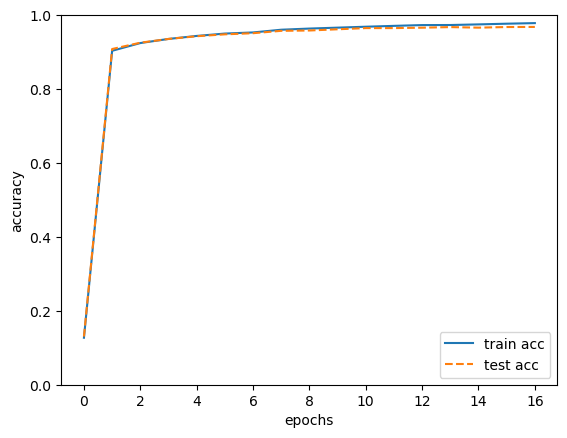

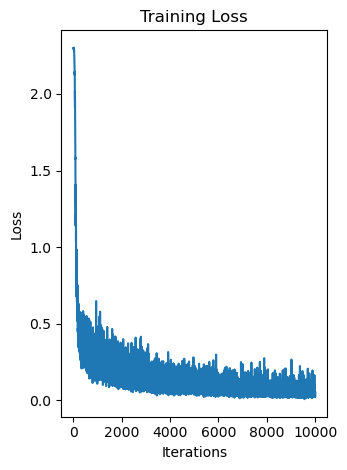

In [11]:
#mini-batch 的反向传播
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset.mnist import load_mnist


# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

#    创建一个输入层784节点（28x28像素）、隐藏层50节点、输出层10节点（对应0-9数字）的神经网络
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)


#超参数
iters_num = 10000  # 适当设定循环的次数
train_size = x_train.shape[0]  # MNIST训练集大小
batch_size = 100 # mini-batch大小
learning_rate = 0.1

train_loss_list = [] # 记录每次迭代的训练损失
train_acc_list = []  # 记录每个epoch结束时的训练准确率
test_acc_list = []   # 记录每个epoch结束时的测试准确率

iter_per_epoch = max(train_size / batch_size, 1) # 每个epoch需要 训练集大小 / 批量大小 = 60000/100 = 600 次迭代

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size) #从范围 [train_size, batch_size-1] 中随机选择 batch_size 个不重复的整数
    x_batch = x_train[batch_mask] #MNIST图像 小批量
    t_batch = t_train[batch_mask] #one-hot标签 小批量
    
    # 计算梯度
    grad = network.gradient(x_batch, t_batch) #选择了反向传播
    
    # 更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]  #参数 = 参数 - 学习率 × 梯度
    
    # 记录损失
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) #将损失值添加到列表中
    
    if i % iter_per_epoch == 0: #每个epoch结束时（每600次迭代）
        train_acc = network.accuracy(x_train, t_train) #计算模型在整个训练集上的准确率
        test_acc = network.accuracy(x_test, t_test) #计算模型在整个测试集上的准确率
        train_acc_list.append(train_acc) #记录这些准确率值
        test_acc_list.append(test_acc) #打印当前epoch和准确率信息
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 绘制损失图像
plt.subplot(1, 2, 2)
x_iter = np.arange(len(train_loss_list))
plt.plot(x_iter, train_loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.tight_layout()
plt.show()

5.梯度确认

In [ ]:

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
from dataset.mnist import load_mnist

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3] # 取前3个训练样本
t_batch = t_train[:3] # 对应的标签

grad_numerical = network.numerical_gradient(x_batch, t_batch) # 数值梯度（正向梯度）
grad_backprop = network.gradient(x_batch, t_batch) # 反向传播梯度

for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) ) #计算每个元素的绝对误差，并求平均，差异 < 1e-7说明反向传播正确
    print(key + ":" + str(diff))

W1:4.4999639222826673e-10
b1:2.761148699502577e-09
W2:5.209284192970546e-09
b2:1.4006546222855576e-07


例

In [13]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)

import numpy as np
from dataset.mnist import load_mnist


# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 梯度
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)


0.13518333333333332 0.143
0.9067166666666666 0.9089
0.9237666666666666 0.9279
0.9387 0.9393
0.9471 0.9438
0.9531666666666667 0.9512
0.9583833333333334 0.9538
0.9616333333333333 0.9585
0.9656166666666667 0.96
0.96805 0.9637
0.97005 0.9641
0.9710333333333333 0.9659
0.9731666666666666 0.966
0.9732666666666666 0.9673
0.9765833333333334 0.9672
0.97745 0.9667
0.9793333333333333 0.969
